In [ ]:
#Import Library
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU
from tensorflow.keras import regularizers

In [ ]:
#global variable
NUM_WORDS = 1000
OOV_TOKEN = "<OOV>"
PADDING = 'post'
MAXLEN = 120
EMBEDDING_DIM = 16

In [ ]:
#Retrieve DS from Github
dataset_link = 'https://raw.githubusercontent.com/Willie29/capstone-C23-PS056/main/ML/Dataset_Combined.csv'
response = requests.get(dataset_link)

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Willie29/capstone-C23-PS056/main/ML/Dataset_Combined.csv')
# Identify Unnamed columns
unnamed_columns = [col for col in data.columns if 'Unnamed' in col]

# Drop Unnamed columns
data = data.drop(unnamed_columns, axis=1)
#shuffle data
data = data.sample(frac=1)

print(data.head())
print("\n")
print(data.tail())

       Label                                              Tweet
2856      HS  kalo mau bercanda itu coba kata katanya di sar...
374   Non_HS  Semangat pak ahok , bapak sudah berjuang sekua...
2892      HS  Coba bayangin kalo lu digituin sekali2 ngertii...
3326      HS                        Menyalak apa lg woi bangsat
2449      HS  "Musik milenial emang sampah, mending dibilang...


       Label                                              Tweet
1381  Non_HS  sebelum menjalankan mobil periksa dan astikan ...
1350  Non_HS  setahun dah kat yaman sik berasa waktu eh haha...
3377      HS                                      Halah bangsat
2948      HS  Kami yang kamu anggap biadab ini yang turut me...
1114  Non_HS  untunglah boleh baik semula aku ada beberapa k...


In [ ]:
data['Label'].value_counts()

HS        1722
Non_HS    1688
Name: Label, dtype: int64

In [ ]:
def parse_data(data):
    labels = []
    tweets = []

    for _, row in data.iterrows():
        cond = (0 if row['Label'] == "HS" else 1)
        labels.append(cond)
        tweets.append(row['Tweet'])

    return labels, tweets

# Assuming 'data' is your DataFrame
labels, tweets = parse_data(data)

In [ ]:
print(f"Example number in dataset is {len(tweets)} examples\n")

print(f"2nd example:\n{tweets[1]}\n")
print(f"Last example:\n{tweets[-1]}")

Example number in dataset is 3410 examples

2nd example:
Semangat pak ahok , bapak sudah berjuang sekuat tenaga dan sudah berusaha melakukan yang terbaik, terima kasih pak

Last example:
untunglah boleh baik semula aku ada beberapa kawan yang dulu ngam gila sekarang biasa biasaekarang


In [ ]:
#90-10 ratio train-test
def train_test_split(labels,tweets):
    train_size = int(len(tweets) * 0.9)

    train_labels = labels[:train_size]
    train_tweets = tweets[:train_size]

    test_labels = labels[train_size:]
    test_tweets = tweets[train_size:]

    return train_labels, train_tweets, test_labels, test_tweets

In [ ]:
train_labels, train_tweets, test_labels, test_tweets = train_test_split(labels, tweets)

print(f" {len(train_labels)} sentences for training.")
print(f" {len(train_tweets)} labels for training.")
print(f" {len(test_labels)} sentences for validation.")
print(f" {len(test_tweets)} labels for validation.")

 3069 sentences for training.
 3069 labels for training.
 341 sentences for validation.
 341 labels for validation.


In [ ]:
print(train_tweets[:3])
print(train_labels[:3])
print(test_tweets[:3])
print(test_labels[:3])

['kalo mau bercanda itu coba kata katanya di saring dulu mana yang menyakitkan mana yang enggak mana yang sesuai fa', 'Semangat pak ahok , bapak sudah berjuang sekuat tenaga dan sudah berusaha melakukan yang terbaik, terima kasih pak', 'Coba bayangin kalo lu digituin sekali2 ngertiin dia lah jangan kamu mulu yang maunya dingertiin']
[0, 1, 0]
['Ngakak asw wkwkw', 'kebiasaan balajaer nyampah d ig para artis..suka2 yang punya ig lah mau bikin caption apa,kok balajaer yang heboh dan asik ceramahin yang punya ig.tar lama2 d bikinin lagu sm teh melly loh balajaer yang berjudul"ketika balajaer bersabda"demi seonggak koin laknat nya.balajaer ngamuk berarti mengiyakan banget koin laknat nya jd penggoda d rt nya gigi.duh elah balajaer kami smua tau kale kelakuan biduan lo itu kek apa.minus segala2nya!lagi masih d bela mati2an,pd sakit jiwa', 'tahu diri aja bisa gak sih da kamu tuh cuma prioritas ke 6 nya dia udah ya tahu diri gausah banyak minta']
[0, 0, 0]


In [ ]:
#tokenizer function
def fit_tokenizer(train_sentences, num_words, oov_token):
    tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)
    tokenizer.fit_on_texts(train_sentences)
    return tokenizer

In [ ]:
#buat test doang
def lowercase(list_sentence):
    lower_sentence = list_sentence
    for i in range(len(list_sentence)):
        lower_sentence[i] = lower_sentence[i].lower()
    return lower_sentence

In [ ]:
#tokenize sentence
#test_tweets1 = test_tweets[0].lower()
#test_tweets1 = test_tweets1.lower()
lower_train_tweets = lowercase(train_tweets)
tokenizer = fit_tokenizer(lower_train_tweets, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index
print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 8426 words

<OOV> token included in vocabulary


In [ ]:
#seq and padding function
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen = maxlen, padding = padding)
    return padded_sequences

In [ ]:
#seq and padding sentence
lower_val_tweets = lowercase(test_tweets)
train_padded_seq = seq_and_pad(lower_train_tweets, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(lower_val_tweets, tokenizer, PADDING, MAXLEN)
print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (3069, 120)

Padded validation sequences have shape: (341, 120)


In [ ]:
#Model Structure
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length = MAXLEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units = 32, activation= 'relu'),
    tf.keras.layers.Dense(units = 2, activation='softmax')
])

In [ ]:
print(type(test_labels))

<class 'list'>


In [ ]:
test_labels_changed = np.array(test_labels)
print(type(test_labels_changed))
print(type(train_padded_seq))
print(type(val_padded_seq))
print(type(train_labels))
print("\n")
print(train_padded_seq)
print("\n")
print(val_padded_seq)
print(test_labels_changed[:10])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>


[[ 50  21   1 ...   0   0   0]
 [328  17   8 ...   0   0   0]
 [345   1  50 ...   0   0   0]
 ...
 [  1  46 127 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 [  7  84  51 ...   0   0   0]]


[[371 503   1 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 [234 233  20 ...   0   0   0]
 ...
 [  1  35   0 ...   0   0   0]
 [157   3   7 ...   0   0   0]
 [  1 119  47 ...   0   0   0]]
[0 0 0 1 0 0 0 0 0 1]


In [ ]:
train_labels_changed = np.array(train_labels)
print(train_labels_changed)

[0 1 0 ... 1 0 0]


In [ ]:
# Menggunakan LabelEncoder untuk mengubah label menjadi bilangan bulat
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_changed)
test_labels_encoded = label_encoder.transform(test_labels_changed)

# Mengubah label menjadi one-hot encoded
num_classes = len(label_encoder.classes_)
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_encoded, num_classes=num_classes)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=num_classes)

In [ ]:
print(train_labels_encoded)
print("\n")
print(test_labels_encoded)
print("\n")
print(train_labels_one_hot)
print("\n")
print(test_labels_one_hot)

[0 1 0 ... 1 0 0]


[0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0
 0 1 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 0
 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0
 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0
 1 1 0 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0
 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1
 0 1 1 1 1 0 0 1]


[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam() ,metrics=['accuracy'])

history_1 = model.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
96/96 [==============================] - 1s 6ms/step - loss: 0.6928 - accuracy: 0.5099 - val_loss: 0.6932 - val_accuracy: 0.4721
Epoch 2/30
96/96 [==============================] - 0s 3ms/step - loss: 0.6899 - accuracy: 0.5318 - val_loss: 0.6869 - val_accuracy: 0.7654
Epoch 3/30
96/96 [==============================] - 0s 4ms/step - loss: 0.6769 - accuracy: 0.6693 - val_loss: 0.6751 - val_accuracy: 0.4927
Epoch 4/30
96/96 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.7471 - val_loss: 0.6160 - val_accuracy: 0.7713
Epoch 5/30
96/96 [==============================] - 0s 3ms/step - loss: 0.5561 - accuracy: 0.8433 - val_loss: 0.5414 - val_accuracy: 0.7683
Epoch 6/30
96/96 [==============================] - 0s 4ms/step - loss: 0.4657 - accuracy: 0.8530 - val_loss: 0.4699 - val_accuracy: 0.8387
Epoch 7/30
96/96 [==============================] - 0s 4ms/step - loss: 0.3965 - accuracy: 0.8635 - val_loss: 0.4283 - val_accuracy: 0.8446
Epoch 8/30
96/96 [==

**Melihat Grafik dari model sebelum fine tuning**

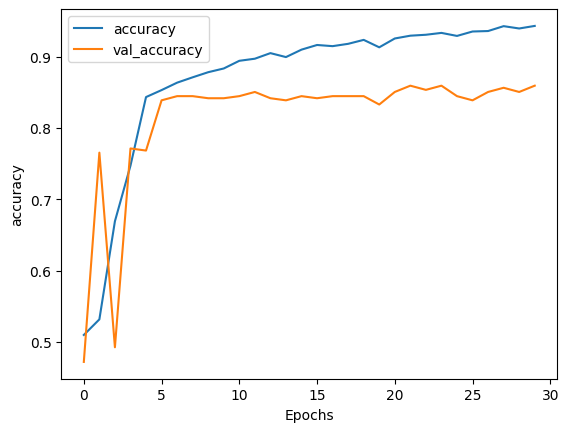

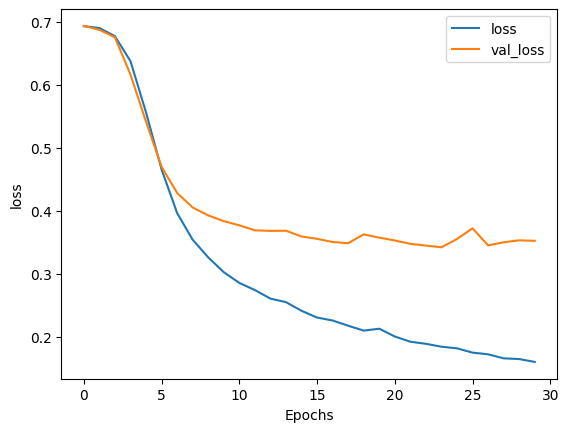

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history_1, "accuracy")
plot_graphs(history_1, "loss")

In [ ]:
seed_text = "anjing liar"
# Convert the text into sequences
token_list = tokenizer.texts_to_sequences([seed_text])[0]
# Pad the sequences
token_list = pad_sequences([token_list], maxlen=MAXLEN , padding='pre')
# Get the probabilities of predicting a word
predicted = model.predict(token_list, verbose=0)
print("[HS             ,      non-HS]")
print(predicted)

[HS             ,      non-HS]
[[0.5360325  0.46396753]]


**Fine Tuning**

In [ ]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Bidirectional(LSTM(16, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=2, activation='softmax')
])
model_LSTM.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_LSTM = model_LSTM.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
96/96 [==============================] - 41s 308ms/step - loss: 0.6934 - accuracy: 0.4998 - val_loss: 0.6929 - val_accuracy: 0.5279
Epoch 2/30
96/96 [==============================] - 21s 218ms/step - loss: 0.6921 - accuracy: 0.5165 - val_loss: 0.6863 - val_accuracy: 0.4839
Epoch 3/30
96/96 [==============================] - 20s 207ms/step - loss: 0.4823 - accuracy: 0.7797 - val_loss: 0.5063 - val_accuracy: 0.7507
Epoch 4/30
96/96 [==============================] - 21s 221ms/step - loss: 0.3953 - accuracy: 0.8602 - val_loss: 0.4470 - val_accuracy: 0.8328
Epoch 5/30
96/96 [==============================] - 20s 203ms/step - loss: 0.3391 - accuracy: 0.8869 - val_loss: 0.4695 - val_accuracy: 0.8240
Epoch 6/30
96/96 [==============================] - 21s 219ms/step - loss: 0.4227 - accuracy: 0.8097 - val_loss: 0.5098 - val_accuracy: 0.8065
Epoch 7/30
96/96 [==============================] - 20s 204ms/step - loss: 0.3166 - accuracy: 0.8983 - val_loss: 0.4641 - val_accuracy: 0.8152

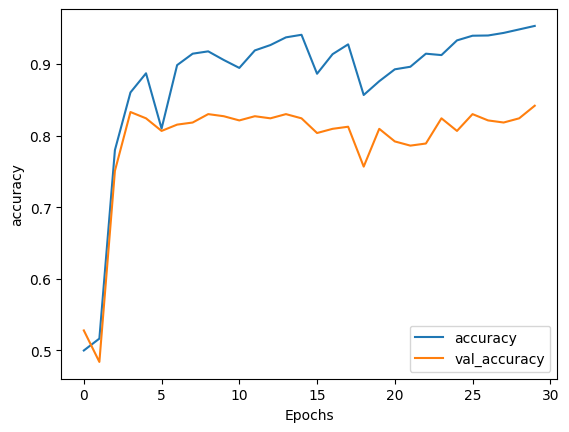

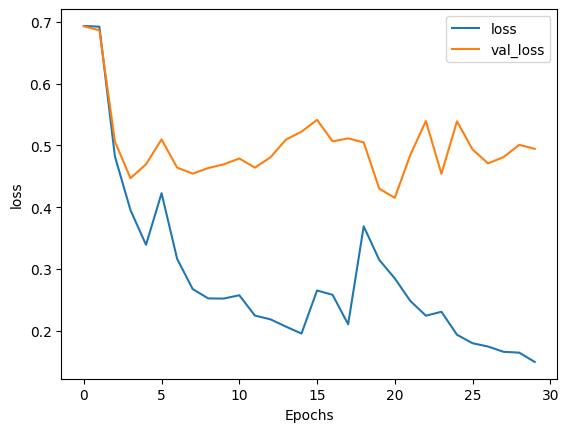

In [ ]:
plot_graphs(history_LSTM, "accuracy")
plot_graphs(history_LSTM, "loss")

In [ ]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Bidirectional(LSTM(16, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=2, activation='softmax')
])
model_LSTM.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
history_LSTM = model_LSTM.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
96/96 [==============================] - 30s 221ms/step - loss: 0.6932 - accuracy: 0.5077 - val_loss: 0.6935 - val_accuracy: 0.4721
Epoch 2/30
96/96 [==============================] - 20s 203ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6938 - val_accuracy: 0.4721
Epoch 3/30
96/96 [==============================] - 19s 203ms/step - loss: 0.6931 - accuracy: 0.5073 - val_loss: 0.6941 - val_accuracy: 0.4721
Epoch 4/30
96/96 [==============================] - 19s 198ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6942 - val_accuracy: 0.4721
Epoch 5/30
96/96 [==============================] - 21s 216ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6942 - val_accuracy: 0.4721
Epoch 6/30
96/96 [==============================] - 20s 213ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6942 - val_accuracy: 0.4721
Epoch 7/30
96/96 [==============================] - 20s 206ms/step - loss: 0.6931 - accuracy: 0.5086 - val_loss: 0.6942 - val_accuracy: 0.4721

In [43]:
# Definisikan callback function
class LearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, schedule):
        super(LearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Dapatkan learning rate berdasarkan epoch saat ini
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        # Panggil fungsi schedule untuk mendapatkan learning rate baru
        scheduled_lr = self.schedule(epoch, lr)
        # Atur learning rate pada optimizer
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print(f"\nEpoch {epoch + 1}: Learning rate set to {scheduled_lr}")

# Fungsi untuk mengatur schedule learning rate
def learning_rate_schedule(epoch, lr):
    # Learning rate akan berkurang setiap 5 epoch
    if epoch % 5 == 0 and epoch > 0:
        lr = lr * 0.1  # Mengurangi learning rate menjadi 10% dari sebelumnya
    return lr

In [44]:
# Membuat model LSTM
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Bidirectional(LSTM(16, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

# Compile model
# Adam Opt
model_LSTM.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Membuat instance dari LearningRateScheduler
lr_scheduler = LearningRateScheduler(learning_rate_schedule)

# Latih model dengan menggunakan callback LearningRateScheduler
history_LSTM = model_LSTM.fit(train_padded_seq, train_labels_one_hot, epochs=30,
                              validation_data=(val_padded_seq, test_labels_one_hot),
                              callbacks=[lr_scheduler])


Epoch 1: Learning rate set to 0.0010000000474974513
Epoch 1/30
96/96 [==============================] - 37s 251ms/step - loss: 0.6935 - accuracy: 0.4966 - val_loss: 0.6939 - val_accuracy: 0.4721

Epoch 2: Learning rate set to 0.0010000000474974513
Epoch 2/30
96/96 [==============================] - 20s 213ms/step - loss: 0.6918 - accuracy: 0.5178 - val_loss: 0.6520 - val_accuracy: 0.6188

Epoch 3: Learning rate set to 0.0010000000474974513
Epoch 3/30
96/96 [==============================] - 25s 260ms/step - loss: 0.4518 - accuracy: 0.8358 - val_loss: 0.4794 - val_accuracy: 0.8270

Epoch 4: Learning rate set to 0.0010000000474974513
Epoch 4/30
96/96 [==============================] - 23s 239ms/step - loss: 0.4056 - accuracy: 0.8530 - val_loss: 0.4682 - val_accuracy: 0.8123

Epoch 5: Learning rate set to 0.0010000000474974513
Epoch 5/30
96/96 [==============================] - 22s 231ms/step - loss: 0.3333 - accuracy: 0.8850 - val_loss: 0.4114 - val_accuracy: 0.8328

Epoch 6: Learning r

In [45]:
# SGD Opt
model_LSTM.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
history_LSTM = model_LSTM.fit(train_padded_seq, train_labels_one_hot, epochs=30,
                              validation_data=(val_padded_seq, test_labels_one_hot),
                              callbacks=[lr_scheduler])


Epoch 1: Learning rate set to 0.009999999776482582
Epoch 1/30
96/96 [==============================] - 33s 235ms/step - loss: 0.6415 - accuracy: 0.6061 - val_loss: 0.6862 - val_accuracy: 0.5308

Epoch 2: Learning rate set to 0.009999999776482582
Epoch 2/30
96/96 [==============================] - 22s 228ms/step - loss: 0.6778 - accuracy: 0.5842 - val_loss: 0.6701 - val_accuracy: 0.6921

Epoch 3: Learning rate set to 0.009999999776482582
Epoch 3/30
96/96 [==============================] - 23s 235ms/step - loss: 0.6351 - accuracy: 0.8061 - val_loss: 0.5828 - val_accuracy: 0.8182

Epoch 4: Learning rate set to 0.009999999776482582
Epoch 4/30
96/96 [==============================] - 23s 239ms/step - loss: 0.4768 - accuracy: 0.8449 - val_loss: 0.6359 - val_accuracy: 0.6217

Epoch 5: Learning rate set to 0.009999999776482582
Epoch 5/30
96/96 [==============================] - 23s 235ms/step - loss: 0.6790 - accuracy: 0.5653 - val_loss: 0.6915 - val_accuracy: 0.5279

Epoch 6: Learning rate s